In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
template = gnn.Dataset('data/template',make_template=True)

In [3]:
dataset = gnn.concat_dataset([f'data/{mass}-training' for mass in eightb.mass_list],transform=gnn.to_uptri_graph)
len(dataset)

451169

In [4]:
testing = gnn.concat_dataset([f'data/{mass}-testing' for mass in eightb.mass_list],transform=gnn.to_uptri_graph)
len(testing)

492279

In [12]:
from torch_geometric.loader import DataLoader
from torch.utils.data import RandomSampler

# training,validation = gnn.train_test_split(dataset,0.2)

# trainloader = DataLoader(training,batch_size=100,shuffle=True,num_workers=4)
# validloader = DataLoader(validation,batch_size=100,num_workers=4)

testsample,_ = gnn.train_test_split(testing,0.9)
testloader = DataLoader(testsample,batch_size=100,num_workers=16)

In [16]:
# model = gnn.GoldenGCN(dataset)
model = gnn.GoldenGCN.load_from_checkpoint("models/golden_classifier/lightning_logs/version_3/checkpoints/epoch=9-step=39389.ckpt",dataset=template)


In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = pl.Trainer(max_epochs=10, gpus=1 if gnn.useGPU else 0,
                     default_root_dir="models/golden_classifier")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [7]:
# trainer.fit(model, trainloader, validloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type          | Params
----------------------------------------------
0 | conv1       | GCNConvMSG    | 384   
1 | relu1       | GCNRelu       | 0     
2 | conv2       | GCNConvMSG    | 20.6 K
3 | relu2       | GCNRelu       | 0     
4 | node_linear | NodeLinear    | 258   
5 | edge_linear | EdgeLinear    | 770   
6 | log_softmax | GCNLogSoftmax | 0     
----------------------------------------------
22.0 K    Trainable params
0         Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)


/uscms/home/ekoenig/nobackup/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 9: 100%|██████████| 578/578 [00:11<00:00, 51.12it/s, loss=2.01, v_num=2]


In [17]:
test_results = trainer.test(model,testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing:   1%|▏         | 7/493 [00:03<02:51,  2.83it/s]

/uscms/home/ekoenig/nobackup/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Testing: 100%|█████████▉| 491/493 [00:18<00:00, 33.27it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7982882261276245, 'test_loss': 1.9451879262924194}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 493/493 [00:18<00:00, 26.65it/s]


In [18]:
node_metrics,edge_metrics = gnn.get_model_roc(model,testloader)

In [19]:
print(node_metrics.get_wps())
print(edge_metrics.get_wps())

[[0.2        0.86559681 0.55680031]
 [0.1        0.72535296 0.61217254]
 [0.05       0.60180732 0.78237247]]
[[0.2        0.83679873 0.5399332 ]
 [0.1        0.65438925 0.73860532]
 [0.05       0.47096681 0.83388293]]


(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

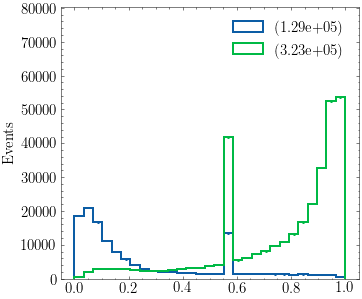

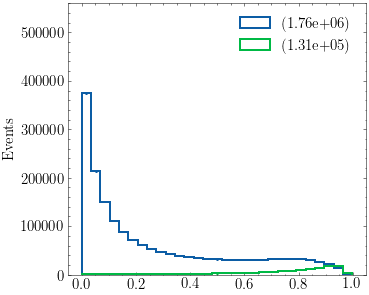

In [20]:
hist_multi([node_metrics.pred[node_metrics.true==0],node_metrics.pred[node_metrics.true==1]],density=0)
hist_multi([edge_metrics.pred[edge_metrics.true==0],edge_metrics.pred[edge_metrics.true==1]],density=0)

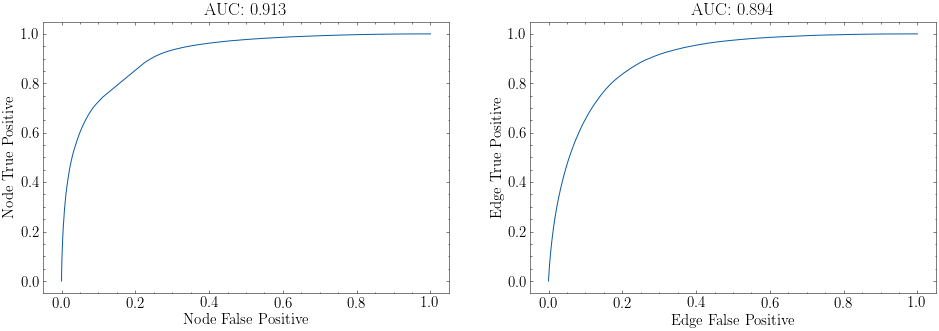

In [21]:
fig,ax = gnn.plot_graph_auroc(node_metrics,edge_metrics)